# AITEX FABRIC IMAGE DATABASE
- https://www.aitex.es/afid/

## Data
- The textile fabric database consists of 245 images of 7 different fabrics
- Images have a size of 4096×256 pixels
- There are 140 defect-free images, 20 for each type of  fabric
- With different types of defects, there are 105 images


## Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
% cd ./drive/MyDrive/colab_notebook/image/

/content/drive/MyDrive/colab_notebook/image


## Data set

In [ ]:
! pip install opencv-python

In [ ]:
import cv2
import os
import glob
import shutil
import random
import string
import numpy as np

In [ ]:
PATH_DEFECT = 'dataset/Defect_images/'
PATH_MASK = 'dataset/Mask_images/'
PATH_NODEFECT = 'dataset/NODefect_images/'

In [ ]:
random.seed(0)

defect_list = glob.glob(PATH_DEFECT + '*.png')
mask_list = glob.glob(PATH_MASK + '*.png')
pass_list = glob.glob(PATH_NODEFECT + '**/*.png')

# Match defect-mask pairs
new_defect_list = list()
new_mask_list = list()
for defect in defect_list:
    num = defect.split('/')[-1].split('_')[0]
    for mask in mask_list:
        num_mask = mask.split('/')[-1].split('_')[0]
        if num == num_mask:
            new_defect_list.append(defect)
            new_mask_list.append(mask)
            break
defect_list = new_defect_list
mask_list = new_mask_list

In [ ]:
# train dataset
if os.path.exists('dataset/OK') is False:
    os.mkdir('dataset/OK')
if os.path.exists('dataset/FAIL') is False:
    os.mkdir('dataset/FAIL')
if os.path.exists('dataset/MASK') is False:
    os.mkdir('dataset/MASK')

idx = 0
for file_name in pass_list:
    img = cv2.imread(file_name)
    height, width, _ = img.shape
    step = height // 2

    for i in range(width // step):
        w = i * step
        if w < width - height and random.randint(0, 9) < 3:
            patch = img[:, w:w+height, :]
            cv2.imwrite('dataset/OK/%04d.png' % idx, patch)
            idx += 1 

patch_pair_list = list()

for item in zip(defect_list, mask_list):
    defect, mask = item

    img_d = cv2.imread(defect)
    img_m = cv2.imread(mask)

    height, width, _ = img_d.shape
    step = height // 2
    for i in range(width // step):
        w = i * step
        if w < width - height:
            patch = img_d[:, w:w+height, :]
            patch_d = img_m[:, w:w+height, :]

            if patch_d.sum() > 0:
                patch_pair_list.append((patch, patch_d))

random.shuffle(patch_pair_list)
for idx, pair in enumerate(patch_pair_list):
    patch, patch_d = pair
    cv2.imwrite('dataset/FAIL/%04d.png' % idx, patch)
    cv2.imwrite('dataset/MASK/%04d.png' % idx, patch_d)

In [ ]:
# The test dataset
if os.path.exists('data/') is False:
    os.mkdir('data/')
if os.path.exists('tfrecords/') is False:
    os.mkdir('tfrecords/')
if os.path.exists('model/') is False:
    os.mkdir('model/')
if os.path.exists('data/input_data') is False:
    os.mkdir('data/input_data')
if os.path.exists('data/output_csv') is False:
    os.mkdir('data/output_csv')
    
idx = 0
for file_name in pass_list:
    img = cv2.imread(file_name)
    height, width, _ = img.shape
    step = height // 2

    for i in range(width // step):
        w = i * step
        if w < width - height and random.randint(0, 9) < 5:
            patch = img[:, w:w+height, :]
            cv2.imwrite('data/input_data/ok_%04d.png' % idx, patch)
            idx += 1 

patch_pair_list = list()
for item in zip(defect_list, mask_list):
    defect, mask = item

    img_d = cv2.imread(defect)
    img_m = cv2.imread(mask)

    height, width, _ = img_d.shape
    step = height // 2
    for i in range(width // step):
        w = i * step
        if w < width - height:
            patch = img_d[:, w:w+height, :]
            patch_d = img_m[:, w:w+height, :]

            if patch_d.sum() > 0:
                patch_pair_list.append((patch, patch_d))

random.shuffle(patch_pair_list)
for idx, pair in enumerate(patch_pair_list):
    patch, patch_d = pair
    cv2.imwrite('data/input_data/fail_%04d.png' % idx, patch)

## Data Preprocessing
* TFRecord Builder
  * Data Serialization to learn faster

In [ ]:
import glob
import os
import tensorflow as tf
import cv2

Paths and Hyperparameters

In [ ]:
DATASET_OK_PATTERN = 'dataset/OK/*.png'
DATASET_FAIL_PATTERN = 'dataset/FAIL/*.png'

# to serialize the data into binary
TFRECORD_PATH = 'tfrecords/'
IMAGE_PER_TFRECORD = 100

Import data

In [ ]:
ok_list = glob.glob(DATASET_OK_PATTERN)
fail_list = glob.glob(DATASET_FAIL_PATTERN)

num_ok = len(ok_list)
num_fail = len(fail_list)

# Oversampling
# to make the number of fail datas equal to number of ok datas
fail_list_new = list()
for _ in range(num_ok // num_fail):
    fail_list_new += fail_list
fail_list_new += fail_list[:num_ok % num_fail]
fail_list = fail_list_new

ok_label = [0] * len(ok_list)
fail_label = [1] * len(fail_list)

file_list = ok_list + fail_list
label_list = ok_label + fail_label

TFRecord functions

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(image_string, label):
    image_shape = tf.image.decode_image(image_string).shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

Write TFRecords

In [ ]:
if os.path.exists(TFRECORD_PATH) is False:
    os.mkdir(TFRECORD_PATH)
    
num_tfrecords = len(file_list) // IMAGE_PER_TFRECORD
if len(file_list) % IMAGE_PER_TFRECORD != 0:
    num_tfrecords += 1
    
for idx in range(num_tfrecords):
    idx0 = idx * IMAGE_PER_TFRECORD
    idx1 = idx0 + IMAGE_PER_TFRECORD
    record_file = TFRECORD_PATH + '%05d.tfrecords' % idx
    with tf.io.TFRecordWriter(record_file) as writer:
        for filename, label in zip(file_list[idx0:idx1],
                                  label_list[idx0:idx1]):
            image_string = open(filename, 'rb').read()
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())

## Model learning

In [ ]:
! pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Concatenate, Flatten, Dense

Hyper parameter

In [ ]:
EPOCHS = 1000
RESULT_SAVE_PATH = 'results/'

### Function define

Inception-based model function

In [ ]:
def Model():
    def inception(filters):
        def subnetwork(x):
            h1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
            h1 = MaxPool2D()(h1)
            
            h2 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(h2)
            h2 = MaxPool2D()(h2)
            
            h3 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(h3)
            h3 = MaxPool2D()(h3)
            return Concatenate()([h1, h2, h3])
        return subnetwork
    
    x = tf.keras.Input(shape=(256, 256, 3))
    h = inception(16)(x)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = Flatten()(h)
    h = Dense(1024, activation='relu')(h)
    y = Dense(1, activation='sigmoid')(h)
    return tf.keras.Model(inputs=x, outputs=y)

Data preprocessing function

In [ ]:
def preprocess(img):
    return tf.image.convert_image_dtype(img, tf.float32)

Data Augmentation function
- do filp, rotate, translation

In [ ]:
def augmentation(img, label):
    def flip(x):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)
        return x
    
    def rotate(x):
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                   lambda: tfa.image.rotate(x,
                                       tf.random.uniform(shape=[], minval=0.0, maxval=360.0, dtype=tf.float32),
                                       interpolation='BILINEAR'),
                   lambda: x)
        return x
    
    def translation(x):
        dx = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        dy = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                    lambda: tfa.image.transform(x,
                                                [0, 0, dx, 0, 0, dy, 0, 0],
                                                interpolation='BILINEAR'),
                    lambda: x)
        return x
    
    img = flip(img)
    img = rotate(img)
    img = translation(img)
           
    return img, label

Load TFRecords

In [ ]:
tffiles = glob.glob('tfrecords/*')
raw_image_dataset = tf.data.TFRecordDataset(tffiles)

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _parse_image_label(parsed_dataset):
    return preprocess(tf.image.decode_png(parsed_dataset['image_raw'])), parsed_dataset['label']

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
dataset = parsed_image_dataset.map(_parse_image_label)

Train and Validation set

In [ ]:
ds_size = 0
for _ in dataset:
    ds_size += 1

train_size = int(ds_size * 0.7)

ds = dataset.shuffle(ds_size)
ds_train = ds.take(train_size).shuffle(1024, reshuffle_each_iteration=True).prefetch(1024).batch(32).map(augmentation)
ds_valid = ds.skip(train_size).prefetch(1024).batch(32)

Build a model and start learning

In [ ]:
model = Model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=EPOCHS,
                    callbacks=[earlystopping])

Epoch 1/1000
58/58 [==============================] - 70s 547ms/step - loss: 0.6938 - accuracy: 0.5261 - val_loss: 0.6901 - val_accuracy: 0.4937
Epoch 2/1000
58/58 [==============================] - 34s 522ms/step - loss: 0.6935 - accuracy: 0.5087 - val_loss: 0.6919 - val_accuracy: 0.5076
Epoch 3/1000
58/58 [==============================] - 33s 502ms/step - loss: 0.6930 - accuracy: 0.4995 - val_loss: 0.6874 - val_accuracy: 0.4987
Epoch 4/1000
58/58 [==============================] - 34s 504ms/step - loss: 0.6845 - accuracy: 0.5506 - val_loss: 0.6865 - val_accuracy: 0.5723
Epoch 5/1000
58/58 [==============================] - 34s 514ms/step - loss: 0.6871 - accuracy: 0.5256 - val_loss: 0.6854 - val_accuracy: 0.5063
Epoch 6/1000
58/58 [==============================] - 34s 504ms/step - loss: 0.6937 - accuracy: 0.5147 - val_loss: 0.6887 - val_accuracy: 0.6409
Epoch 7/1000
58/58 [==============================] - 33s 502ms/step - loss: 0.6912 - accuracy: 0.5234 - val_loss: 0.6879 - val_ac

## Plotting

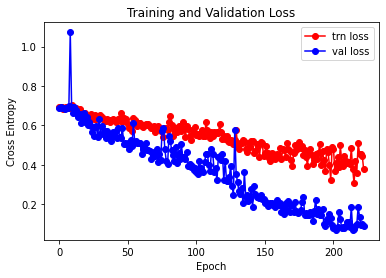

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(loss, 'ro-', label='trn loss')
plt.plot(val_loss, 'bo-' , label='val loss')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- the learning stopped at 223 epoch.
- The result
  * trn_loss: 0.3759
  * trn_accuracy: 0.7557
  * val_loss: 0.0895
  * val_accuracy: 0.9708